# Dernier checkpoint - formation data analyst
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/h4r1c0t/WildCodeSchool/master?filepath=Odyssey%2FCheckpoint%2F%234_Final%2FCP4_sujet1.ipynb)
___
## Sujet n°1 : SQL Database
##### import

In [1]:
# Classical libraries
import pandas as pd
import numpy as np

# SQL connection libraries
import requests
import sqlite3

# Mapping libraries
import geopandas as gpd
import folium
import rtree
from shapely.geometry import Point
from shapely.ops import transform
from IPython.display import display

# Ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
from plotly.offline import plot as op

# Dashboard libraries
import dash

### Open dataset

In [2]:
# Get dataset from github.com
link = 'https://github.com/murpi/wilddata/raw/master/quests/chinook.db'
r = requests.get(link)
open('./datasets/chinook.db', 'wb').write(r.content)

# Create connector
conn = sqlite3.connect('./datasets/chinook.db')
cursor = conn.cursor()

### DB schemas

![schemas](http://images.innoveduc.fr/data/SQL/SQLite_chinook.png)

___
### 1. Mapping of sales by country, and comparison with customer and employee addresses
#### Explore dataset
##### Invoices table:

In [3]:
df_invoices = pd.read_sql("SELECT * FROM invoices", conn)
df_invoices.head(3)

,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,1,2,2009-01-01 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
1,2,4,2009-01-02 00:00:00,Ullevålsveien 14,Oslo,None,Norway,0171,3.96
2,3,8,2009-01-03 00:00:00,Grétrystraat 63,Brussels,None,Belgium,1000,5.94


In [4]:
# Change date format to 'DateTime'
df_invoices['InvoiceDate'] = pd.to_datetime(df_invoices['InvoiceDate'])

df_invoices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   InvoiceId          412 non-null    int64         
 1   CustomerId         412 non-null    int64         
 2   InvoiceDate        412 non-null    datetime64[ns]
 3   BillingAddress     412 non-null    object        
 4   BillingCity        412 non-null    object        
 5   BillingState       210 non-null    object        
 6   BillingCountry     412 non-null    object        
 7   BillingPostalCode  384 non-null    object        
 8   Total              412 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 29.1+ KB


In [5]:
# Isolate the year, month and day of the invoices. 
df_invoices['InvoiceYear'] = df_invoices['InvoiceDate'].apply(lambda x: str(x)[:4])
df_invoices['InvoiceMonth'] = df_invoices['InvoiceDate'].apply(lambda x: str(x)[5:7])
df_invoices['InvoiceDay'] = df_invoices['InvoiceDate'].apply(lambda x: str(x)[8:10])

In [6]:
# Columns filling rate:
round((1 - df_invoices.isna().sum()/len(df_invoices)) *100, 2)

InvoiceId            100.00
CustomerId           100.00
InvoiceDate          100.00
BillingAddress       100.00
BillingCity          100.00
BillingState          50.97
BillingCountry       100.00
BillingPostalCode     93.20
Total                100.00
InvoiceYear          100.00
InvoiceMonth         100.00
InvoiceDay           100.00
dtype: float64

##### Customers table:

In [7]:
df_customers = pd.read_sql("SELECT * FROM customers", conn)
df_customers.head(3)

,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
1,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
2,3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3


In [8]:
# Columns filling rate:
round((1 - df_customers.isna().sum()/len(df_customers)) *100, 2)

CustomerId      100.00
FirstName       100.00
LastName        100.00
Company          16.95
Address         100.00
City            100.00
State            50.85
Country         100.00
PostalCode       93.22
Phone            98.31
Fax              20.34
Email           100.00
SupportRepId    100.00
dtype: float64

##### Employees table:

In [9]:
df_employees = pd.read_sql("SELECT * FROM employees", conn)
df_employees.head(3)

,EmployeeId,LastName,FirstName,Title,ReportsTo,BirthDate,HireDate,Address,City,State,Country,PostalCode,Phone,Fax,Email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2002-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2002-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
2,3,Peacock,Jane,Sales Support Agent,2.0,1973-08-29 00:00:00,2002-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com


In [10]:
# Columns filling rate:
round((1 - df_employees.isna().sum()/len(df_employees)) *100, 2)

EmployeeId    100.0
LastName      100.0
FirstName     100.0
Title         100.0
ReportsTo      87.5
BirthDate     100.0
HireDate      100.0
Address       100.0
City          100.0
State         100.0
Country       100.0
PostalCode    100.0
Phone         100.0
Fax           100.0
Email         100.0
dtype: float64

#### Turnover per country

In [11]:
df_turnover_country = df_invoices.groupby(
    by = [
    'BillingCountry', 
    'InvoiceYear'
#         , 
#     'InvoiceMonth'
    ]
).sum(
).reset_index(
).drop(
    ['InvoiceId', 'CustomerId'], 
    axis = 1
).rename(
    columns = {
        'BillingCountry': 'Country', 
        'InvoiceYear': 'Year', 
#         'InvoiceMonth': 'Month', 
        'Total': 'Turnover'}
)

df_turnover_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Country   101 non-null    object 
 1   Year      101 non-null    object 
 2   Turnover  101 non-null    float64
dtypes: float64(1), object(2)
memory usage: 2.5+ KB


#### Map creation
##### Import countries coordinates from geo.json

In [12]:
# Import geo.json data 
world = "https://raw.githubusercontent.com/h4r1c0t/WildCodeSchool/master/Odyssey/Checkpoint/%234_Final/Sujet1/datasets/world.geo.json"
df_world = gpd.read_file(world)
df_world.shape

(232, 65)

In [13]:
# Rename USA to 'United States of America' to match the geo.json DF
df_turnover_country['Country'][df_turnover_country['Country'] == 'USA'] = 'United States of America'

C:\Users\vanst\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
# List of the countries in our DB
countries_to_keep = df_turnover_country['Country'].unique()

> There is **232** countries in the *geo.json* file, but only **24** in our dataset. 

In [15]:
# Keep only the countries which are in our dataset
df_country = df_world[['admin', 'geometry']][df_world['admin'].isin(countries_to_keep)]
df_country.shape

(24, 2)

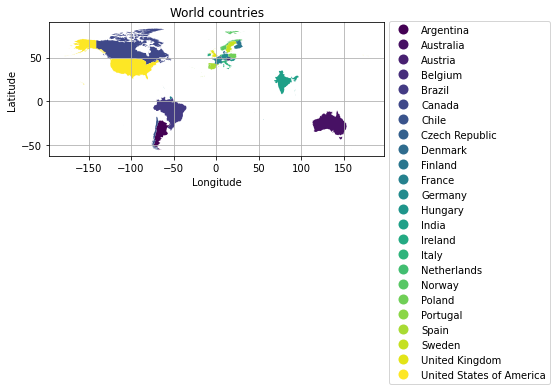

In [16]:
# Show selected contries on simple map

legend_param = {'loc':'upper left', 'bbox_to_anchor': (1, 1.05)}

df_country.plot(column = 'admin',  cmap = 'viridis', legend = True, legend_kwds = legend_param)
plt.title('World countries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

##### Join df_turnover_country and the geo.json

In [17]:
df_turnover_geo = pd.merge(df_country, df_turnover_country, left_on = 'admin', right_on = 'Country').drop('Country', axis = 1)
df_turnover_geo.head()

,admin,geometry,Year,Turnover
0,Canada,"MULTIPOLYGON (((-59.78760 43.93960, -59.92227 ...",2009,57.42
1,Canada,"MULTIPOLYGON (((-59.78760 43.93960, -59.92227 ...",2010,76.26
2,Canada,"MULTIPOLYGON (((-59.78760 43.93960, -59.92227 ...",2011,55.44
3,Canada,"MULTIPOLYGON (((-59.78760 43.93960, -59.92227 ...",2012,42.57
4,Canada,"MULTIPOLYGON (((-59.78760 43.93960, -59.92227 ...",2013,72.27


##### Map with Turnover Chlorepleth

In [18]:
map_data = df_turnover_geo[df_turnover_geo['Year'] == '2010']
map_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 20 entries, 1 to 99
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   admin     20 non-null     object  
 1   geometry  20 non-null     geometry
 2   Year      20 non-null     object  
 3   Turnover  20 non-null     float64 
dtypes: float64(1), geometry(1), object(2)
memory usage: 800.0+ bytes


In [19]:
turnover_map = folium.Map(location = [45, 0], zoom_start = 2)

turnover_map.choropleth(
    geo_data = map_data,
    name = 'Turnover',
    data = map_data,
    columns = ['admin', 'Turnover'],
    key_on = 'feature.properties.admin',
    fill_color = 'Blues',
    fill_opacity = .5,
    line_opacity = 1.0,
    legend_name = 'Turnover by country'
)   

# tunover_map.add

folium.LayerControl().add_to(turnover_map)


display(turnover_map)

C:\Users\vanst\miniconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


##### Add Customers localisation

In [20]:
cities = "https://raw.githubusercontent.com/h4r1c0t/geojson-world-cities/master/cities.geojson"
df_cities = gpd.read_file(cities)
df_cities.shape

(34472, 2)

In [21]:
# Keep only cities which are in customers DF
cust_cities = df_customers.City.unique()

# Keep only cities which are in employees DF
empl_cities = df_employees.City.unique()

In [22]:
# How many cities? 
print("Nb customers cities: " + str(len(cust_cities)))
print("Nb employees cities: " + str(len(empl_cities)))

Nb customers cities: 53
Nb employees cities: 3


In [23]:
# Cities to uppercase
cust_cities = [x.upper() for x in cust_cities]
empl_cities = [x.upper() for x in empl_cities]

In [24]:
# Replace the punctuation 
def punct_replacer(x):
    pnct = {"Ã": "A", "É": "E", "Í": "I"}
    list = []
    for word in x: 
        for a, b in zip(pnct.keys(), pnct.values()):
            word = word.replace(a, b)
        list.append(word.strip())
    return list

## For customers_cities 
cust_cities = punct_replacer(cust_cities)

## For customers_cities
empl_cities = punct_replacer(empl_cities)

In [25]:
df_cities['NAME'] = punct_replacer(df_cities['NAME'])

In [26]:
df_cust_cities = df_cities[['NAME', 'geometry']][df_cities['NAME'].isin(cust_cities)]

df_empl_cities = df_cities[['NAME', 'geometry']][df_cities['NAME'].isin(empl_cities)]

In [27]:
print('Nb customers cities coordinate: ' + str(len(df_cust_cities.NAME.unique())))
print('Nb employees cities coordinate: ' + str(len(df_empl_cities.NAME.unique())))

Nb customers cities coordinate: 49
Nb employees cities coordinate: 3


> 3 customers' cities are not in our geo.json file.. To bad. 

___
### 2. Preferred music format and genre
#### Get data

In [45]:
query = """
    SELECT  g.Name Genre, mt.Name Format, 
            TotalOrdered
    FROM tracks t
    JOIN (
        SELECT TrackId, SUM(Quantity) TotalOrdered
        FROM invoice_items
        GROUP BY TrackId
    ) ii 
    ON ii.TrackId = t.TrackId
    JOIN (
        SELECT *
        FROM genres
    ) g 
    ON g.GenreId = t.GenreId
    JOIN (
        SELECT * 
        FROM media_types
    ) mt
    ON mt.MediaTypeId = t.MediaTypeId
"""

df_favO = pd.read_sql(query, conn)


#### Favorite **genre** based on Total ordered 

In [52]:
df_favO_genre = df_favO.groupby(["Genre"]).sum().sort_values("TotalOrdered", ascending = False).reset_index()
df_favO_genre.head()

,Genre,TotalOrdered
0,Rock,835
1,Latin,386
2,Metal,264
3,Alternative & Punk,244
4,Jazz,80


##### BarChart

In [197]:
x = df_favO_genre['Genre']
y = df_favO_genre['TotalOrdered']

fig = [go.Bar(x = x, y = y)]
op(fig)

'temp-plot.html'

##### PieChart

In [151]:
labels = df_favO_genre['Genre']
values = df_favO_genre['TotalOrdered']

fig = [go.Pie(labels = labels, values = values)]
op(fig)

'temp-plot.html'

#### Favorite **format** based on Total ordered 

In [68]:
df_favO_format = df_favO.groupby(["Format"]).sum().sort_values("TotalOrdered", ascending = False).reset_index()
df_favO_format.head()

,Format,TotalOrdered
0,MPEG audio file,1976
1,Protected AAC audio file,146
2,Protected MPEG-4 video file,111
3,Purchased AAC audio file,4
4,AAC audio file,3


In [149]:
labels = df_favO_format['Format']
values = df_favO_format['TotalOrdered']

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole = .25)])
fig.update_traces(hoverinfo='label+value', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=1.5)))
op(fig)

'temp-plot.html'

___
### 3. Most represented artists
#### Get data

In [181]:
query = """
    SELECT Artist, Genre, COUNT(TrackId) Number
    FROM tracks t 
    JOIN (
        SELECT Name Genre, GenreId
        FROM genres
    ) g ON g.GenreId = t.GenreId
    JOIN (
        SELECT AlbumId, ArtistId
        FROM albums
    ) alb ON alb.AlbumId = t.AlbumId
    JOIN (
        SELECT Name Artist, ArtistId
        FROM artists
    ) art ON art.ArtistId = alb.ArtistId
    GROUP BY Artist, Genre 
    ORDER BY Number DESC
"""

df_artist = pd.read_sql(query, conn)
df_artist.head()

,Artist,Genre,Number
0,Led Zeppelin,Rock,114
1,Metallica,Metal,112
2,U2,Rock,112
3,Iron Maiden,Metal,95
4,Deep Purple,Rock,92


In [182]:
genres = df_artist.groupby(["Genre"]).sum().sort_values(['Number'], ascending = False).reset_index()
genres.head()

,Genre,Number
0,Rock,1297
1,Latin,579
2,Metal,374
3,Alternative & Punk,332
4,Jazz,130


In [185]:
for genre in genres['Genre']:
    nb_tracks = int(genres["Number"][genres["Genre"] == genre])
    df_artist['Freq'][df_artist['Genre'] == genre] = df_artist['Number'][df_artist['Genre'] == genre].apply(lambda x: x/nb_tracks*100)
    
df_artist.head()

C:\Users\vanst\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Artist,Genre,Number,Freq
0,Led Zeppelin,Rock,114,8.789514
1,Metallica,Metal,112,29.946524
2,U2,Rock,112,8.635312
3,Iron Maiden,Metal,95,25.401070
4,Deep Purple,Rock,92,7.093292


In [201]:
genres = ['Rock', 'Metal']
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure()

for genre, color in zip(genres, colors):
    
    x = df_artist['Artist'][df_artist['Genre'] == genre]
    y = df_artist['Freq'][df_artist['Genre'] == genre]
    
    fig.add_trace([go.Bar(x, y, color = color)])
    



ValueError: The first argument to the plotly.graph_objs.Bar 
constructor must be a dict or 
an instance of :class:`plotly.graph_objs.Bar`

___
### 4. Prediction of top-selling music and determination of the criteria associated with them
#### Generate a track sales DF

In [ ]:
query = """
    SELECT  t.TrackId, Name, ArtistId, t.AlbumId, 
            MediaTypeId, GenreId, Composer, 
            Milliseconds, Bytes, UnitPrice, 
            TotalOrdered
    FROM tracks t
    JOIN (
        SELECT TrackId, SUM(Quantity) TotalOrdered
        FROM invoice_items
        GROUP BY TrackId
    ) ii
    ON t.TrackId = ii.TrackId
    JOIN (
        SELECT AlbumId, ArtistId
        FROM albums
    ) a
"""

df_tracks = pd.read_sql(query, conn)
df_tracks.head()

In [ ]:
df_tracks.info()

In [ ]:
df_tracks.describe(include='all').T

##### Data vizualisation

In [ ]:
# Pairplot
sns.pairplot(df_tracks, hue = "MediaTypeId")
plt.show()

In [ ]:
# Heatmap
sns.heatmap(df_tracks.corr(), annot = True)

In [ ]:
df_tracks.groupby(["GenreId", "ArtistId"]).sum().sort_values("TotalOrdered", ascending = False)

In [ ]:
pd.read_sql("SELECT * FROM genres WHERE GenreId = 1", conn)

In [ ]:
pd.read_sql("SELECT * FROM artists WHERE ArtistId = 22", conn)